In [1]:
import pandas as pd
import numpy as np

# csv 파일에서 불러오기
r_cols = ["user_id", "movie_id", "rating", "timestamp"]
ratings = pd.read_csv(
    "./ml-100k/u.data", names=r_cols, sep="\t", encoding="latin-1"
)
ratings = ratings[["user_id", "movie_id", "rating"]].astype(int)  # timestamp 제거

# train test 분리
from sklearn.utils import shuffle

TRAIN_SIZE = 0.75
ratings = shuffle(ratings)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

# 수정된 부분 1 >>>>>>>>>>
u_cols = ["user_id", "age", "sex", "occupation", "zip_code"]
users = pd.read_csv("./ml-100k/u.user", sep="|", names=u_cols, encoding="latin-1")
users = users[["user_id", "occupation"]]

# Convert occupation(string to integer)
occupation = {}


def convert_occ(x):
    if x in occupation:
        return occupation[x]
    else:
        occupation[x] = len(occupation)
        return occupation[x]


users["occupation"] = users["occupation"].apply(convert_occ)

L = len(occupation)
train_occ = pd.merge(ratings_train, users, on="user_id")["occupation"]
test_occ = pd.merge(ratings_test, users, on="user_id")["occupation"]
# <<<<<<<<< 수정된 부분 1

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam, Adamax

# Variable 초기화
K = 200  # Latent factor 수
mu = ratings_train.rating.mean()  # 전체 평균
M = ratings.user_id.max() + 1  # Number of users
N = ratings.movie_id.max() + 1  # Number of movies


# Defining RMSE measure
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))


##### (2)

# Keras model
user = Input(shape=(1,))
item = Input(shape=(1,))
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)

# Concatenate layers
from tensorflow.keras.layers import Dense, Concatenate, Activation

P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)

# 수정된 부분 2 >>>>>>>>>>
occ = Input(shape=(1,))
occ_embedding = Embedding(L, 3, embeddings_regularizer=l2())(occ)
occ_layer = Flatten()(occ_embedding)
R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, occ_layer])
# <<<<<<<<< 수정된 부분 2

# Neural network
R = Dense(2048)(R)
R = Activation("relu")(R)
R = Dense(256)(R)
R = Activation("linear")(R)
R = Dense(1)(R)

# 수정된 부분 3 >>>>>>>>>>
model = Model(inputs=[user, item, occ], outputs=R)
# <<<<<<<<< 수정된 부분 3
model.compile(
    loss=RMSE,
    optimizer=SGD(),
    # optimizer=Adamax(),
    metrics=[RMSE],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 200)               188800    ['input_1[0][0]']             
                                                                                              

In [3]:
# Model fitting
result = model.fit(
    x=[ratings_train.user_id.values, ratings_train.movie_id.values, train_occ.values],
    y=ratings_train.rating.values - mu,
    epochs=65,
    batch_size=512,
    validation_data=(
        [ratings_test.user_id.values, ratings_test.movie_id.values, test_occ.values],
        ratings_test.rating.values - mu,
    ),
)

Epoch 1/65
147/147 [==============================] - 3s 21ms/step - loss: 5.3993 - RMSE: 1.1247 - val_loss: 5.2733 - val_RMSE: 1.1243
Epoch 2/65
147/147 [==============================] - 3s 21ms/step - loss: 5.1545 - RMSE: 1.1240 - val_loss: 5.0356 - val_RMSE: 1.1236
Epoch 3/65
147/147 [==============================] - 3s 19ms/step - loss: 4.9235 - RMSE: 1.1230 - val_loss: 4.8115 - val_RMSE: 1.1229
Epoch 4/65
147/147 [==============================] - 3s 21ms/step - loss: 4.7057 - RMSE: 1.1223 - val_loss: 4.6003 - val_RMSE: 1.1222
Epoch 5/65
147/147 [==============================] - 3s 21ms/step - loss: 4.5004 - RMSE: 1.1216 - val_loss: 4.4010 - val_RMSE: 1.1215
Epoch 6/65
147/147 [==============================] - 3s 19ms/step - loss: 4.3067 - RMSE: 1.1211 - val_loss: 4.2131 - val_RMSE: 1.1208
Epoch 7/65
147/147 [==============================] - 3s 20ms/step - loss: 4.1241 - RMSE: 1.1201 - val_loss: 4.0358 - val_RMSE: 1.1201
Epoch 8/65
147/147 [==============================] - 3

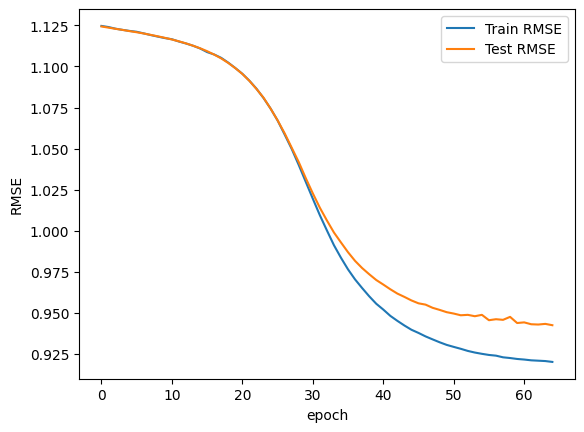

1/1 [==============================] - 0s 72ms/step
Actuals: 
        user_id  movie_id  rating
54552      688       259       5
97188      896       802       2
18335      299       543       5
90796      748       300       4
76271      455       239       3
87189      860        26       3

Predictions: 
 [[3.7770655]
 [2.1984982]
 [3.3754735]
 [3.4922237]
 [3.46173  ]
 [3.159665 ]]
782/782 [==============================] - 1s 2ms/step


0.9432529864779652

In [4]:
# Plot RMSE
import matplotlib.pyplot as plt

plt.plot(result.history["RMSE"], label="Train RMSE")
plt.plot(result.history["val_RMSE"], label="Test RMSE")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()

# Prediction
user_ids = ratings_test.user_id.values[0:6]
movie_ids = ratings_test.movie_id.values[0:6]
user_occ = test_occ[0:6]
predictions = model.predict([user_ids, movie_ids, user_occ]) + mu
print("Actuals: \n", ratings_test[0:6])
print()
print("Predictions: \n", predictions)


# 정확도(RMSE)를 계산하는 함수
def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred)) ** 2))


user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values
y_pred = model.predict([user_ids, movie_ids, test_occ]) + mu
y_pred = np.ravel(y_pred, order="C")
y_true = np.array(ratings_test.rating)

RMSE2(y_true, y_pred)